In [1]:
import xarray as xr             # to open and manipulate data arrays 
import xskillscore as xs        # calculating skill scores
import cfgrib                   # to open GRIB files
import xesmf as xe              # regridding
import numpy as np
      
import os
import os.path
from pathlib import Path

In [2]:
# Plot and mapping
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
# Increase the size of the output figures
plt.rcParams["figure.figsize"] = (16,8)


In [3]:
# To minimise the warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 2.1 Setting up the request for the CDS
If you don't have an account on the [Copernicus Data Store](https://cds.climate.copernicus.eu/#!/home) you need to [register and install the API](https://cds.climate.copernicus.eu/api-how-to)

**Important**: don't forget to insert your key in the following chunk of code

In [11]:
!echo "url: https://cds.climate.copernicus.eu/api/v2" > $HOME/.cdsapirc
!echo "key: INSERT-HERE-YOUR-KEY" >> $HOME/.cdsapirc


In [12]:
import cdsapi

In [13]:
# create a new client
c = cdsapi.Client()

### 2.2 Download climate data: seasonal forecasts
From the CDS you can download the [C3S Seasonal Forecasts](https://climate.copernicus.eu/seasonal-forecasts)

Let's define a list of the models and of the variables available

In [14]:
MODELS = [
    {'centre': 'ecmwf', 'name': 'ECMWF', 'system': '5', 'start_year': 1993, 'end_year': 2016},
    {'centre': 'ukmo', 'name': 'UKMO', 'system': '14', 'start_year': 1993, 'end_year': 2016},
    {'centre': 'meteo_france', 'name': 'MF', 'system': '6', 'start_year': 1993, 'end_year': 2016},
    {'centre': 'dwd', 'name': 'DWD', 'system': '2', 'start_year': 1993, 'end_year': 2016},
    {'centre': 'cmcc', 'name': 'CMCC', 'system': '3', 'start_year': 1993, 'end_year': 2016}
]

VARS = [
    {'source': 'seasonal-monthly-single-levels', 'short_name': 'mslp', 'var': 'mean_sea_level_pressure', 'pressure_level': None, 'xarray_var':'msl'},
    {'source': 'seasonal-monthly-single-levels', 'short_name': 'u10', 'var': '10m_u_component_of_wind', 'pressure_level': None, 'xarray_var':'u10'},
    {'source': 'seasonal-monthly-single-levels', 'short_name': 'ws', 'var': '10m_wind_speed', 'pressure_level': None, 'xarray_var':'ws10'},
    {'source': 'seasonal-monthly-single-levels', 'short_name': 't2m', 'var': '2m_temperature', 'pressure_level': None, 'xarray_var':'t2m'},
    {'source': 'seasonal-monthly-single-levels', 'short_name': 'prec', 'var': 'total_precipitation', 'pressure_level': None, 'xarray_var':'tp'},
    {'source': 'seasonal-monthly-single-levels', 'short_name': 'ssr', 'var': 'surface_solar_radiation', 'pressure_level': None, 'xarray_var':'ssr'}
]

Now we select the starting month of the forecast, the model (selected from the `MODELS` dictionary) and the variable (from `VARS`)

In [15]:
START_MONTH = 6
M  = MODELS[0]
V  = VARS[0]

Now we can prepare the dictionary containing the request for the CDS API. We will download the monthly seasonal forecast from the starting month for the next 4 months (from M+0 to M+3)

In [16]:
request_dict = {
                'originating_centre': M['centre'],
                'variable':V['var'],
                'product_type':'monthly_mean',
                'year':[x for x in map(str, range(M['start_year'], M['end_year']))],
                'month': str(START_MONTH),
                'leadtime_month':[
                    '1', '2','3','4'
                ],
                'format':'grib',
                'system': M['system']
            }
print(request_dict)

{'originating_centre': 'ecmwf', 'variable': 'mean_sea_level_pressure', 'product_type': 'monthly_mean', 'year': ['1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015'], 'month': '6', 'leadtime_month': ['1', '2', '3', '4'], 'format': 'grib', 'system': '5'}


The request is sent and the file downloaded if not already present. The download from the CDS **may take up to one hour**

In [17]:
seasonal_target_filename = M['name']+'-'+V['short_name']+'-'+'S'+str(START_MONTH)+'-L1-4.grib'

if not Path(seasonal_target_filename).exists():
    print('Downloading ' + seasonal_target_filename)
    c.retrieve(
                V['source'],
                request_dict,
                seasonal_target_filename)
else:
    print('Using the file ' + seasonal_target_filename + ' already downloaded')

2020-10-05 14:27:59,799 INFO Welcome to the CDS
2020-10-05 14:27:59,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-10-05 14:28:00,091 INFO Request is queued
2020-10-05 14:28:01,126 INFO Request is running
2020-10-05 14:29:15,290 INFO Request is completed
2020-10-05 14:29:15,291 INFO Downloading http://136.156.133.41/cache-compute-0013/cache/data2/adaptor.mars.external-1601900880.4418466-1648-24-f60bfe62-1507-448c-982e-477bfa8ac1c7.grib to ECMWF-mslp-S6-L1-4.grib (286.4M)
2020-10-05 14:31:38,659 INFO Download rate 2M/s    


### 2.3 Download ERA5
Now we download the ERA5 data for the verification. 

In [18]:
request_dict = {
                'variable':V['var'],
                'product_type':'monthly_averaged_reanalysis',
                'year':[x for x in map(str, range(M['start_year'], M['end_year']))],
                'month': [x for x in map(str, range(START_MONTH+1, START_MONTH+3+1))],
                'format':'grib',
                'time': '00:00'
            }
print(request_dict)

{'variable': 'mean_sea_level_pressure', 'product_type': 'monthly_averaged_reanalysis', 'year': ['1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015'], 'month': ['7', '8', '9'], 'format': 'grib', 'time': '00:00'}


In [19]:
era5_target_filename = 'era5-monthly-'+V['short_name']+'-'+str(M['start_year'])+'-'+str(M['end_year'])+'-'+'S'+str(START_MONTH)+'-L1-4.grib'
if not Path(era5_target_filename).exists():
    print('Downloading ' + era5_target_filename)
    c.retrieve(
                'reanalysis-era5-single-levels-monthly-means',
                request_dict,
                era5_target_filename)
else:
    print('Using the ERA5 file ' + era5_target_filename + ' already downloaded')

2020-10-05 14:31:39,765 INFO Welcome to the CDS
2020-10-05 14:31:39,766 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means


2020-10-05 14:31:41,857 INFO Request is queued
2020-10-05 14:31:42,893 INFO Request is running
2020-10-05 14:32:14,569 INFO Request is completed
2020-10-05 14:32:14,570 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data5/adaptor.mars.internal-1601901102.7101755-24140-3-d027ff06-8b15-4c2b-9545-569a19294ee9.grib to era5-monthly-mslp-1993-2016-S6-L1-4.grib (136.6M)
2020-10-05 14:33:21,489 INFO Download rate 2M/s    


### 2.4 Regrid and compute
We regrid seasonal forecasts and reanalysis on the same grid. For the seasonal forecasts (`ftc`) we also compute the ensemble mean (`fct_final_ensmean`)

In [20]:
# Defining the grid
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89, 89, 1)),
                     'lon': (['lon'], np.arange(0, 360, 1))})

In [21]:
fct = xr.open_dataset(seasonal_target_filename, engine='cfgrib').isel(step = slice(1,4)).mean(dim = 'step').rename({'latitude':'lat', 'longitude': 'lon'})

2020-10-05 14:33:31,099 INFO missing from GRIB stream: 'directionNumber'
2020-10-05 14:33:31,100 INFO missing from GRIB stream: 'frequencyNumber'


In [22]:
regridder = xe.Regridder(fct, ds_out, 'bilinear')

Overwrite existing file: bilinear_181x360_178x360.nc 
 You can set reuse_weights=True to save computing time.


In [23]:
fct_final = regridder(fct)

using dimensions ('lat', 'lon') from data variable msl as the horizontal dimensions for this dataset.


In [24]:
fct_final_ensmean = fct_final.mean('number')

In [25]:
fct_final_ensmean

<xarray.Dataset>
Dimensions:  (lat: 178, lon: 360, time: 23)
Coordinates:
  * time     (time) datetime64[ns] 1993-06-01 1994-06-01 ... 2015-06-01
    surface  int64 ...
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) int64 -89 -88 -87 -86 -85 -84 -83 ... 82 83 84 85 86 87 88
Data variables:
    msl      (time, lat, lon) float64 1.011e+05 1.011e+05 ... 1.012e+05

In [26]:
obs = xr.open_dataset(era5_target_filename, engine = 'cfgrib')

2020-10-05 14:33:46,604 INFO missing from GRIB stream: 'directionNumber'
2020-10-05 14:33:46,605 INFO missing from GRIB stream: 'frequencyNumber'


In [27]:
obs_y = obs.groupby('time.year').mean('time').rename({'latitude':'lat', 'longitude': 'lon'})

In [28]:
# REGRIDDING 1 DEGREE (OBS)
regridder = xe.Regridder(obs_y, ds_out, 'bilinear')

Overwrite existing file: bilinear_721x1440_178x360.nc 
 You can set reuse_weights=True to save computing time.


In [29]:
obs_final = regridder(obs_y).rename({'year':'time'})

using dimensions ('lat', 'lon') from data variable msl as the horizontal dimensions for this dataset.


In [30]:
obs_final['time'] = fct.time # this is needed because xskillscore expects 
print(obs_final)


<xarray.Dataset>
Dimensions:  (lat: 178, lon: 360, time: 23)
Coordinates:
    number   int64 0
    step     timedelta64[ns] 00:00:00
    surface  int64 0
  * time     (time) datetime64[ns] 1993-06-01 1994-06-01 ... 2015-06-01
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) int64 -89 -88 -87 -86 -85 -84 -83 ... 82 83 84 85 86 87 88
Data variables:
    msl      (time, lat, lon) float64 1.007e+05 1.007e+05 ... 1.016e+05
Attributes:
    regrid_method:  bilinear


## 3. Calculating metrics and skill scores
We compute in order:

1.    Pearson correlation between observations and ensemble mean
2.    Continuous Ranked Probability score (CRPS)
3.    Brier Skill Score for the upper tercile

All the skill scores are computed using `xskillscore` which uses `properscoring` for the probabilistic ones. 

In [31]:
r = xs.pearson_r(obs_final, fct_final_ensmean, "time")

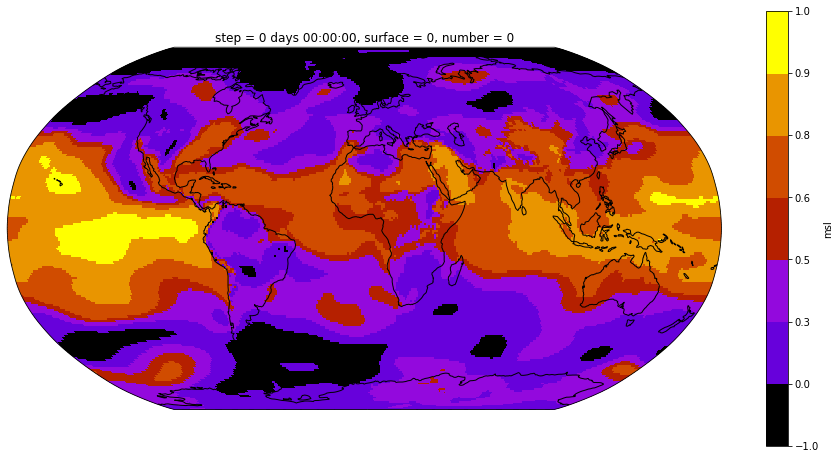

In [32]:
ax = plt.axes(projection=ccrs.Robinson())
p = r[V['xarray_var']].plot(ax=ax, transform=ccrs.PlateCarree(), levels = [-1, 0, 0.3, 0.5, 0.6, 0.8, 0.9, 1], cmap = 'gnuplot')
ax.set_global(); ax.coastlines();

In [33]:
crps_ensemble = xs.crps_ensemble(obs_final, fct_final, member_dim = 'number', dim = ['time'])

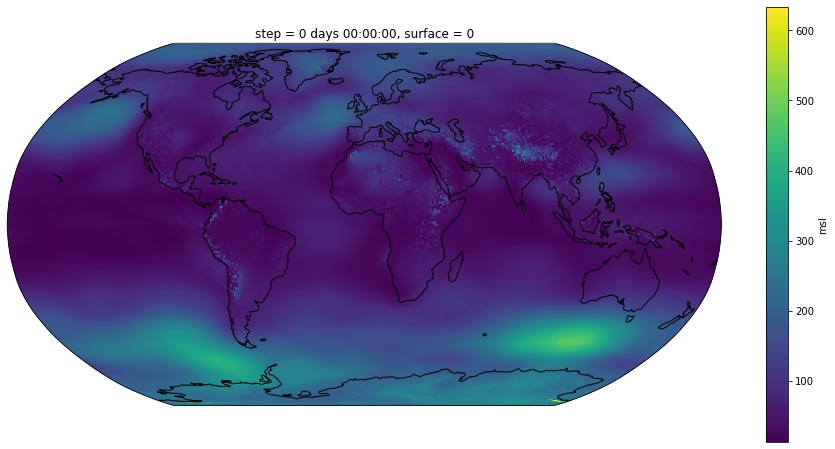

In [34]:
ax = plt.axes(projection=ccrs.Robinson())
crps_ensemble[V['xarray_var']].plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_global(); ax.coastlines();

In [35]:
brier_score = xs.brier_score(obs_final >  obs_final.quantile(2/3, dim = 'time'), (fct_final > fct_final.quantile(2/3, dim = 'time')).mean("number"), dim = 'time')


In [36]:
baseline = xs.brier_score(obs_final >  obs_final.quantile(2/3, dim = 'time'), 2/3, dim = 'time')

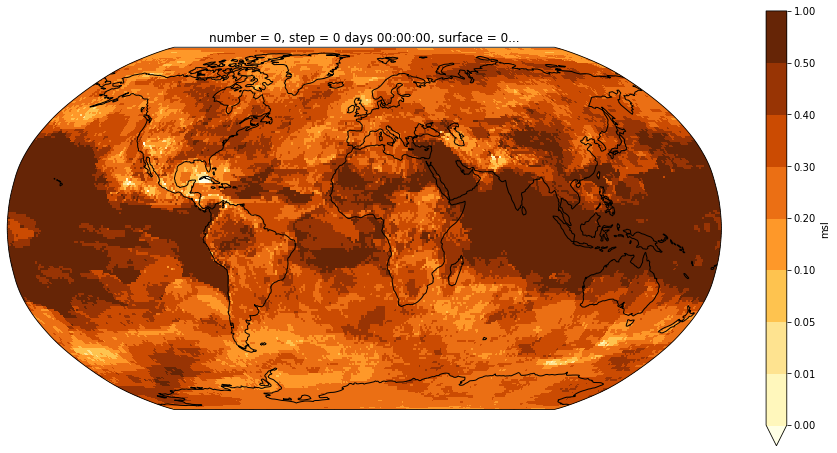

In [37]:
#ax = plt.axes(projection=ccrs.Orthographic(20, 35))
ax = plt.axes(projection=ccrs.Robinson())
(1 - (brier_score/baseline))[V['xarray_var']].plot(ax=ax, transform=ccrs.PlateCarree(), levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1], cmap = 'YlOrBr')
ax.set_global(); ax.coastlines();